In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.io import loadmat

In [3]:
plt.style.use('seaborn-poster')

In [5]:
params = np.zeros((450,7,3), dtype = np.float64)
likelihoods = np.zeros((450,3))
for i in range(0,500,100):
    low = i
    high = i + 100
    if i == 400:
        high = 450
    file = 'params-control-fixed-' + str(low) + '-' + str(high) + '.npz'
    results = np.load(file)
    print(results['params'].shape)
    params += results['params']

(450, 7, 3)
(450, 7, 3)
(450, 7, 3)
(450, 7, 3)
(450, 7, 3)


In [6]:
meta2 = pd.read_excel('../../../../../sample-matching-edited.xlsx')
meta2.at[85,'Class'] = 3.

In [7]:
mu_control = params[:,0,1]
mu = params[:,0,0]

In [8]:
ajj_control = params[:,4,1]
ajj = params[:,4,0]

In [9]:
b = params[:,2,0]
a = params[:,1,0]

In [10]:
label = ['Golvatinib', 'SB590885', 'GDC0879', 'Cabozantinib', 'Pazopanib', 'Tivozanib', 'OSI930']
locs = [262, 169, 53, 62, 281, 85, 87]

In [11]:
basal_mask = meta2['Catalog Number'] == 'DMSO'

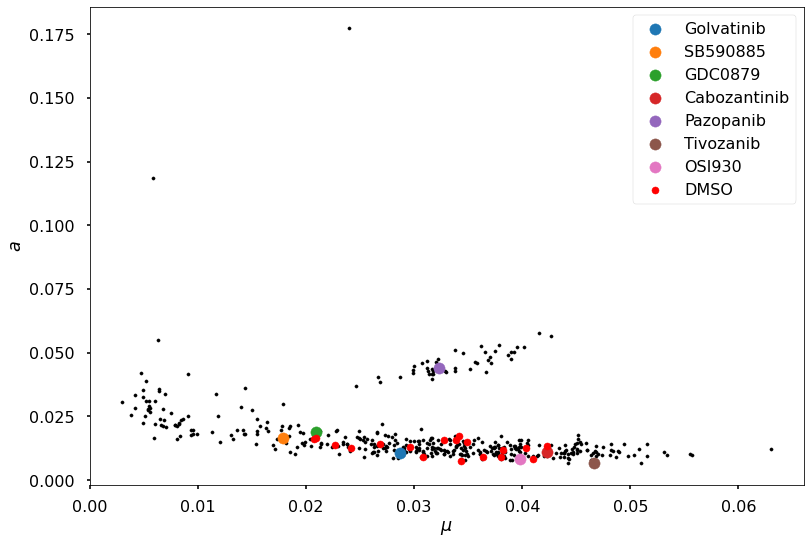

In [12]:
x = mu
y = a
plt.scatter(x,y, s = 10, c = 'k')
for i in range(len(label)):
    plt.scatter(x[locs[i]], y[locs[i]], label = label[i])
plt.scatter(x[basal_mask], y[basal_mask], s = 50, c = 'r', label = 'DMSO')
plt.legend()
plt.xlabel('$\mu$')
plt.ylabel('$a$')
plt.show()

In [13]:
# control_mu

In [14]:
control_mu = np.zeros(450)
dat = loadmat('/tigress/architv/drug-lfm/FINAL_EQ.mat')
for i in range(450):
    if i != 400:
    #print(i)
        well = i
        t = dat['well'][0][well]['t']
        traces = dat['well'][0][well]['PeakTimes']
        peaks = 0
        for j in range(len(traces[0])):
            peaks += len(traces[0][j])
        x = dat['well'][0][well]['x']
        control_mu[i] = peaks/(120 * x.shape[1])

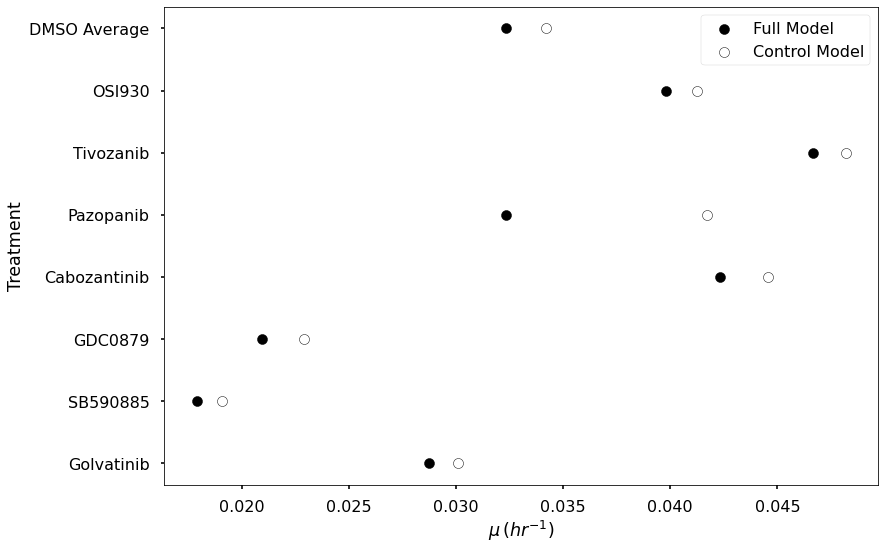

In [15]:
s = 100
fig, ax = plt.subplots()
x = mu[locs]
x2 = control_mu[locs]
y = range(len(locs))
ax.scatter(x,y, c = 'k', s = s, label = 'Full Model')
ax.scatter(x2, y, c = 'w', s = s, edgecolor = 'k', label =  'Control Model')
ax.scatter(np.mean(mu[basal_mask]), [np.max(y) + 1], c = 'k', s = s)
ax.scatter(np.mean(control_mu[basal_mask]), [np.max(y) + 1], c = 'w', s = s, edgecolor = 'k')
#ax.plot([x, x2], [y, y], 'k', linewidth = 1)
#ax.arrow(x,y,dx,dy)
ax.set_yticks(range(0,len(label) + 1))
ax.set_yticklabels(np.append(label, 'DMSO Average'), rotation = 'horizontal')
ax.set_ylabel('Treatment')
ax.set_xlabel('$\mu\, (hr^{-1}$)')
plt.legend()
#plt.savefig('drug-1.pdf')

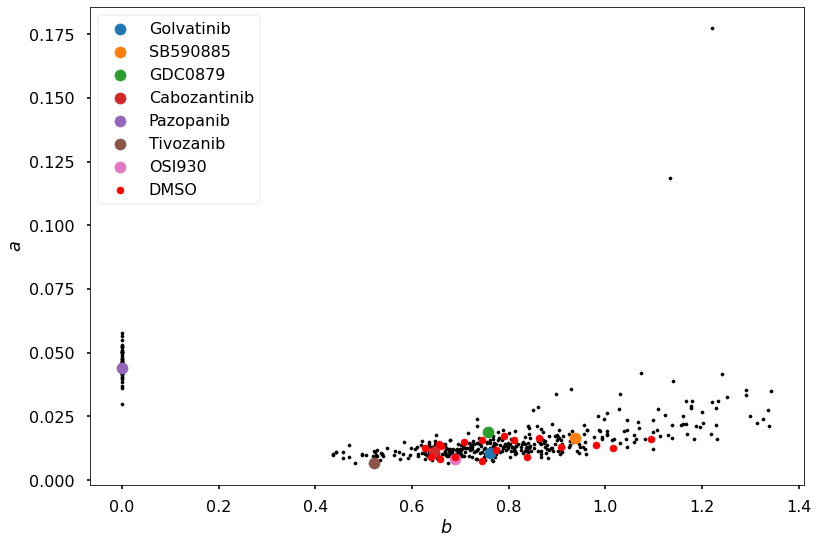

In [16]:
x = b
y = a
plt.scatter(x,y, s = 10, c = 'k')
for i in range(len(label)):
    plt.scatter(x[locs[i]], y[locs[i]], label = label[i])
plt.scatter(x[basal_mask], y[basal_mask], s = 50, c = 'r', label = 'DMSO')
plt.legend()
plt.xlabel('$b$')
plt.ylabel('$a$')
plt.show()

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

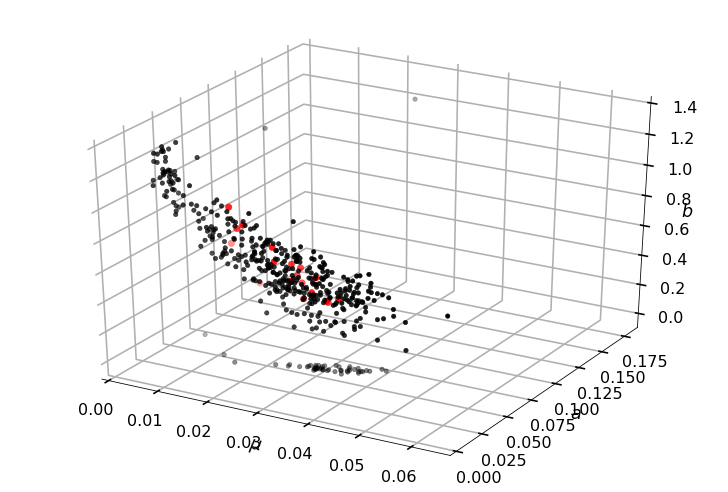

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
not_basal = np.logical_not(basal_mask)
p = ax.scatter(mu[not_basal], a[not_basal], b[not_basal], c = 'k')
p2 = ax.scatter(mu[basal_mask], a[basal_mask], b[basal_mask], c = 'r', s = 40)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$a$')
ax.set_zlabel('$b$')
ax.w_xaxis.set_pane_color((0., 0., 0., 0.))
ax.w_yaxis.set_pane_color((0., 0., 0., 0.))
ax.w_zaxis.set_pane_color((0., 0., 0., 0.))
#fig.colorbar(p)
plt.show()

In [19]:
#np.savetxt('params-combined.csv', params[:,:,0])

In [20]:
from scipy.stats import ttest_ind

In [21]:
target_list = meta2['Target'].str.split(',').values

In [22]:
targets = np.unique(np.hstack(target_list))

In [23]:
membership_mat = np.zeros((450, len(targets)))

In [24]:
for i in range(450):
    if target_list[i] == target_list[i]:
        for j in range(len(targets)):
            if targets[j] in target_list[i]:
                membership_mat[i,j] = 1

In [25]:
np.mean(mu[membership_mat[:,16] == 1])

0.01700832070741453

In [26]:
for i in np.argsort(np.sum(membership_mat, axis = 0)):
    
    mask = membership_mat[:,i] == 1
    stat, p = ttest_ind(mu[mask], mu[basal_mask], equal_var = False)
    if p < 0.05:
        #print(i)
        f1 = targets[i]
        f2 = 100 * (np.mean(mu[mask]) - np.mean(mu[basal_mask]))/np.mean(mu[basal_mask])
        f3 = p
        print(f1 + ' & $\mu$ & ' + '{:.3}'.format(f2) + '\\% &' + '{:.2e}'.format(f3) + ' \\\\ \hline')
        #print(targets[i])
        #print((np.mean(mu[mask]) - np.mean(mu[basal_mask]))/np.mean(mu[basal_mask]))
        #print(p)

CaMK & $\mu$ & 37.2\% &9.49e-07 \\ \hline
TAM Receptor & $\mu$ & 24.2\% &1.82e-03 \\ \hline
PDK & $\mu$ & 30.0\% &1.44e-02 \\ \hline
HER2 & $\mu$ & -59.8\% &1.53e-04 \\ \hline
MEK & $\mu$ & -54.9\% &3.64e-05 \\ \hline
EGFR & $\mu$ & -47.4\% &3.79e-06 \\ \hline


/usr/licensed/anaconda3/2020.7/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/licensed/anaconda3/2020.7/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
for i in np.argsort(np.sum(membership_mat, axis = 0)):
    
    mask = membership_mat[:,i] == 1
    stat, p = ttest_ind(a[mask], a[basal_mask], equal_var = False)
    if p < 0.05:
        #print(i)
        #print(targets[i])
        #print((np.mean(a[mask]) - np.mean(a[basal_mask]))/np.mean(a[basal_mask]))
        #print(p)
        f1 = targets[i]
        f2 = 100 * (np.mean(a[mask]) - np.mean(a[basal_mask]))/np.mean(a[basal_mask])
        f3 = p
        print(f1 + ' & $a$ & ' + '{:.3}'.format(f2) + '\\% &' + '{:.2e}'.format(f3) + ' \\\\ \hline')

Rho & $a$ & -13.5\% &4.77e-02 \\ \hline
TAM Receptor & $a$ & -14.4\% &1.90e-02 \\ \hline
HER2 & $a$ & 92.6\% &4.91e-03 \\ \hline
MEK & $a$ & 1.08e+02\% &8.75e-05 \\ \hline
Akt & $a$ & 1.37e+02\% &1.41e-02 \\ \hline
CDK & $a$ & 43.8\% &3.37e-02 \\ \hline
mTOR & $a$ & 43.3\% &5.25e-03 \\ \hline
EGFR & $a$ & 77.4\% &1.48e-06 \\ \hline
VEGFR & $a$ & 30.2\% &2.81e-02 \\ \hline


In [28]:
for i in np.argsort(np.sum(membership_mat, axis = 0)):
    
    mask = membership_mat[:,i] == 1
    stat, p = ttest_ind(b[mask], b[basal_mask], equal_var = False)
    if p < 0.05:
        #print(i)
        #print(targets[i])
        #print((np.mean(b[mask]) - np.mean(b[basal_mask]))/np.mean(b[basal_mask]))
        #print(p)
        f1 = targets[i]
        f2 = 100 * (np.mean(b[mask]) - np.mean(b[basal_mask]))/np.mean(b[basal_mask])
        f3 = p
        print(f1 + ' & $b$ & ' + '{:.3}'.format(f2) + '\\% &' + '{:.2e}'.format(f3) + ' \\\\ \hline')

CaMK & $b$ & -13.2\% &1.39e-02 \\ \hline
TAM Receptor & $b$ & -34.7\% &3.12e-02 \\ \hline
PAK & $b$ & -19.8\% &4.49e-02 \\ \hline
HER2 & $b$ & 32.0\% &1.46e-03 \\ \hline
c-Met & $b$ & -23.5\% &2.85e-02 \\ \hline
Aurora Kinase & $b$ & -35.3\% &1.21e-03 \\ \hline
EGFR & $b$ & 24.2\% &1.77e-03 \\ \hline


Text(0.5, 0.92, 'EGFR')

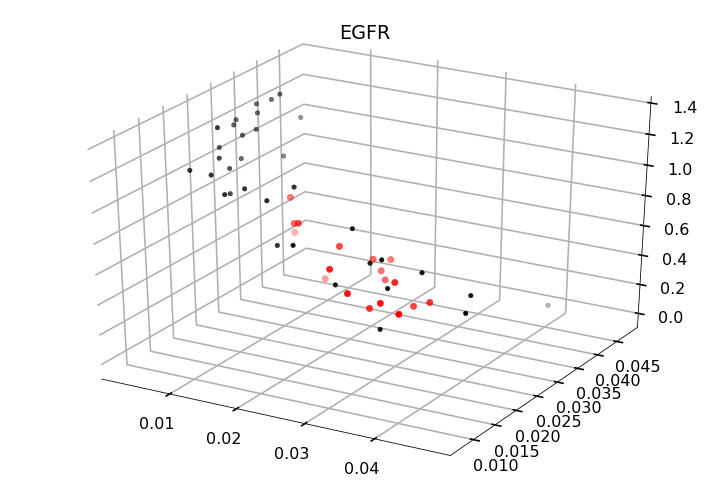

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

i = 16
mask = membership_mat[:,i] == 1


p = ax.scatter(mu[mask], a[mask], b[mask], c = 'k')
p2 = ax.scatter(mu[basal_mask], a[basal_mask], b[basal_mask], c = 'r', s = 40)
#ax.set_xlabel('$\mu$')
#ax.set_ylabel('$a$')
#ax.set_zlabel('$b$')
ax.w_xaxis.set_pane_color((0., 0., 0., 0.))
ax.w_yaxis.set_pane_color((0., 0., 0., 0.))
ax.w_zaxis.set_pane_color((0., 0., 0., 0.))
#fig.colorbar(p)
plt.title(targets[i])
#plt.savefig('drug-3d-' + targets[i] + '.pdf')
#plt.show()

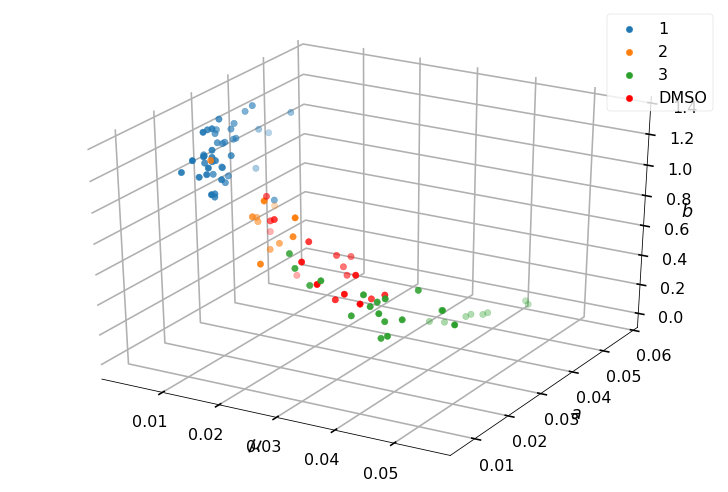

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#not_basal = np.logical_not(basal_mask)
#p = ax.scatter(mu[not_basal], a[not_basal], b[not_basal], c = 'k')
for i in range(1,4):
    mask = meta2['Class'] == i
    ax.scatter(mu[mask], a[mask], b[mask], label = i, s = 40)
ax.scatter(mu[basal_mask], a[basal_mask], b[basal_mask], c = 'r', s = 40, label = 'DMSO')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$a$')
ax.set_zlabel('$b$')
ax.w_xaxis.set_pane_color((0., 0., 0., 0.))
ax.w_yaxis.set_pane_color((0., 0., 0., 0.))
ax.w_zaxis.set_pane_color((0., 0., 0., 0.))
ax.legend()
#fig.colorbar(p)
plt.show()
#plt.savefig('drug-by-class.pdf')

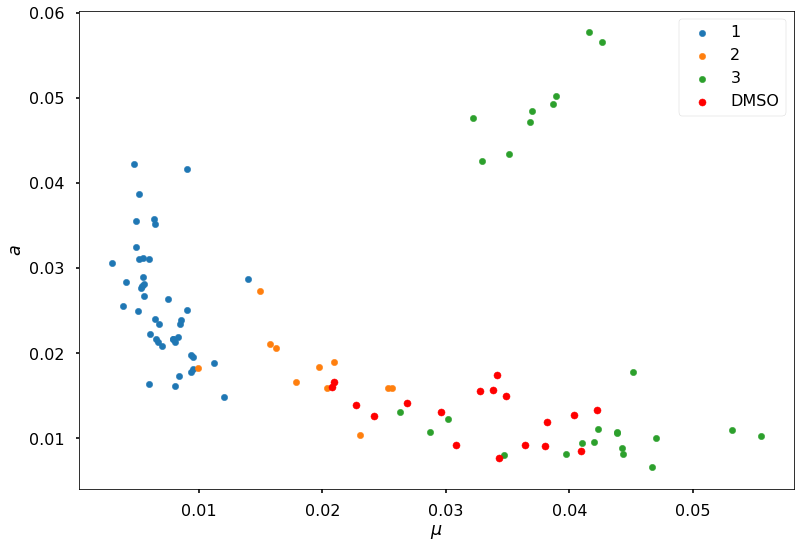

In [31]:
x = mu
y = a
#plt.scatter(x,y, s = 10, c = 'k')
for i in range(1,4):
    mask = meta2['Class'] == i
    plt.scatter(mu[mask], a[mask], label = i, s = 40)
plt.scatter(x[basal_mask], y[basal_mask], s = 50, c = 'r', label = 'DMSO')
plt.legend()
plt.xlabel('$\mu$')
plt.ylabel('$a$')
plt.savefig('drug_by_class_self.pdf')

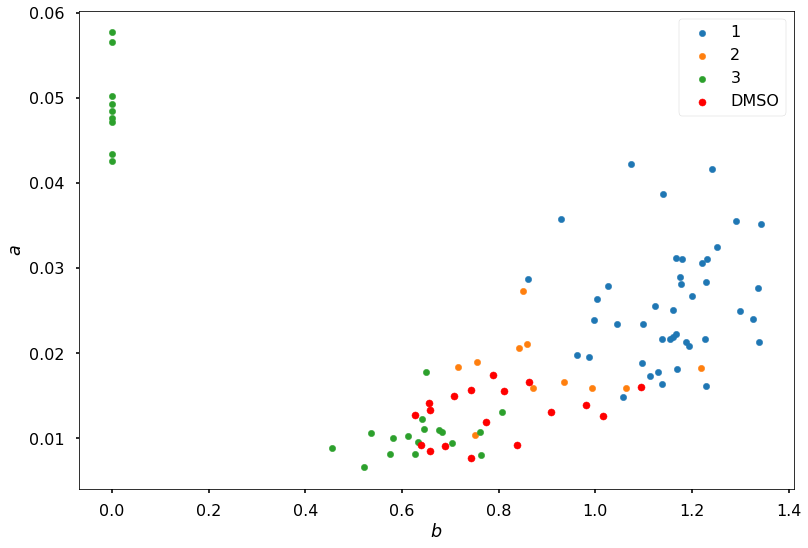

In [32]:
x = b
y = a
#plt.scatter(x,y, s = 10, c = 'k')
for i in range(1,4):
    mask = meta2['Class'] == i
    plt.scatter(x[mask], y[mask], label = i, s = 40)
plt.scatter(x[basal_mask], y[basal_mask], s = 50, c = 'r', label = 'DMSO')
plt.legend()
plt.xlabel('$b$')
plt.ylabel('$a$')
plt.show()

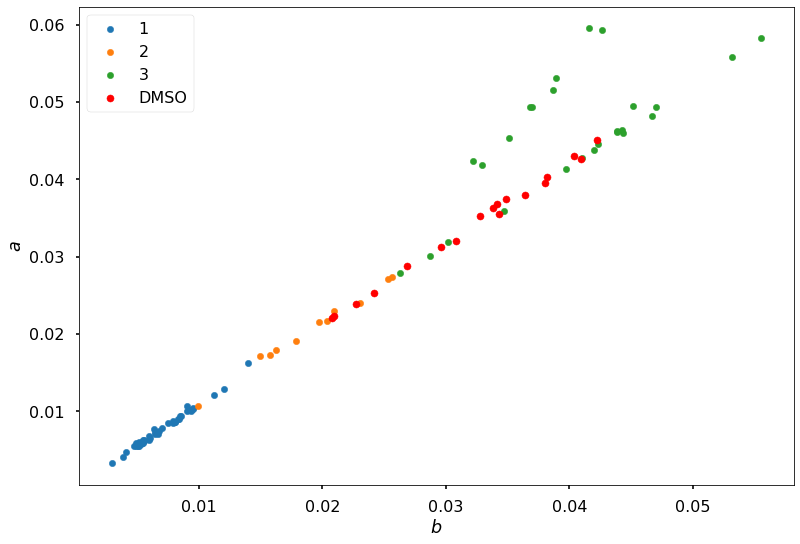

In [33]:
x = mu
y = control_mu
#plt.scatter(x,y, s = 10, c = 'k')
for i in range(1,4):
    mask = meta2['Class'] == i
    plt.scatter(x[mask], y[mask], label = i, s = 40)
plt.scatter(x[basal_mask], y[basal_mask], s = 50, c = 'r', label = 'DMSO')
plt.legend()
plt.xlabel('$b$')
plt.ylabel('$a$')
plt.show()

In [34]:
np.nanmean(control_mu - mu)

0.000517767513801673

In [35]:
100 * np.nanmean(control_mu - mu)/np.mean(control_mu)

1.567765185977748

In [36]:
100 * np.nanmean(a)/np.nanmean(control_mu)

56.67819148179133

In [37]:
for i in range(1,4):
    mask = meta2['Class'] == i
    print(ttest_ind(mu[mask], mu[basal_mask]))

Ttest_indResult(statistic=-21.699561471435903, pvalue=8.25155807337632e-30)
Ttest_indResult(statistic=-5.629069804003224, pvalue=5.652405221338843e-06)
Ttest_indResult(statistic=3.692401532377769, pvalue=0.0006349241667583143)


In [38]:
for i in range(1,4):
    mask = meta2['Class'] == i
    print(ttest_ind(a[mask], a[basal_mask]))

Ttest_indResult(statistic=7.735554906340799, pvalue=1.5337725307775974e-10)
Ttest_indResult(statistic=3.9015605424400674, pvalue=0.0005738982768701683)
Ttest_indResult(statistic=2.393585745146372, pvalue=0.021229265388976053)


In [39]:
for i in range(1,4):
    mask = meta2['Class'] == i
    print(ttest_ind(b[mask], b[basal_mask]))
    print(np.mean(b[mask]) - np.mean(b[basal_mask]))
    print(' ')

Ttest_indResult(statistic=10.794657256918093, pvalue=1.3560019070807208e-15)
0.3643293259565865
 
Ttest_indResult(statistic=1.9709453321453272, pvalue=0.059060980121619366)
0.10751612969112678
 
Ttest_indResult(statistic=-4.6219149677581814, pvalue=3.597174849314195e-05)
-0.37033375990289596
 


In [40]:
meta2['Product Name'][np.argsort(a)][-10:]

355                 GNE-0877
377                   SU9516
124      Quizartinib (AC220)
386                  LFM-A13
392                 Akti-1/2
134                   AT7867
436     7,8-Dihydroxyflavone
438    Perifosine (KRX-0401)
401        ONO-4059 analogue
400                   LJI308
Name: Product Name, dtype: object

In [41]:
a[np.argsort(a)][-10:]

array([0.05237444, 0.05238841, 0.05279608, 0.0528411 , 0.0547938 ,
       0.05655837, 0.05769679, 0.11837197, 0.1771872 ,        nan])

In [42]:
a[281]

0.04410886539138082

In [43]:
np.mean(a[basal_mask])

0.012888456562669048